In [312]:
import numpy as np 
import bagpipes as pipes

from astropy.io import fits

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from matplotlib.widgets import Slider, Button

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

In [337]:
# Define initial parameters
init_z = 0.04
init_logM = 10
init_t_old = 4
init_tau = 1
init_t_burst = 12
init_alpha = 200
init_beta = 200
init_f_burst = 0.5
init_metallicity = 1.0

init_eta = 2.
init_Av = 1.0
init_n_dust = 0.7
init_t_bc = 0.01
init_veldisp = 0

In [340]:
%matplotlib inline
def psb2(t_old, t_burst, tau, alpha, beta, f_burst):
    age = (cosmo.age(0).value - t_old)*10**9
    tau = tau*10**9
    burstage = (cosmo.age(0).value - t_burst)*10**9
    alpha = alpha
    beta = beta
    fburst = f_burst
    age_of_universe = cosmo.age(0).value*10**9
    
    log_age_max = np.log10(cosmo.age(0).value)+9. #+ 2*0.0025
    ages = np.arange(6., log_age_max, 0.0025)
    age_lhs = pipes.utils.make_bins(ages, make_rhs=True)[0]
    ages = 10**ages
    age_lhs = 10**age_lhs
    age_lhs[0] = 0.
    age_lhs[-1] = 10**9*cosmo.age(0).value
    age_widths = age_lhs[1:] - age_lhs[:-1]

    ind = (np.where((ages < age) & (ages > burstage)))[0]
    texp = age - ages[ind]
    sfr_exp = np.exp(-texp/tau) 
    sfr_exp_tot = np.sum(sfr_exp*age_widths[ind])

    mask = ages < age_of_universe
    tburst = age_of_universe - ages[mask]
    tau_plaw = age_of_universe - burstage
    sfr_burst = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr_burst_tot = np.sum(sfr_burst*age_widths[mask])

    sfr = np.zeros_like(ages)
    sfr[ind] = (1-fburst) * np.exp(-texp/tau) / sfr_exp_tot
    sfr[mask] += fburst * (((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1) / sfr_burst_tot
    
    return ages, sfr

def total_mass_at_z(logM, z, t_old, t_burst, tau, alpha, beta, f_burst):
    lb_time, norm_sfr = psb2(t_old, t_burst, tau, alpha, beta, f_burst)
    #psb2 output sfh integrates to around solar mass formed in total
    #calculate the ratio of mass formed up to the given redshift z
    age = cosmo.age(0).value*10**9 - lb_time[::-1]
    norm_sfr = norm_sfr[::-1]
    total_unit_mass = np.trapz(y=norm_sfr, x=age)
    age_before_z = age[age<cosmo.age(z).value*10**9]
    norm_sfr_before_z = norm_sfr[age<cosmo.age(z).value*10**9]
    frac_before_z = np.trapz(y=norm_sfr_before_z, x=age_before_z)/total_unit_mass
    
    #create custom sfh array that is before z for input to model components
    #requirements: column 0 = lookback time at z in years, column 1 = SFR in Msuns per year
    lb_time_before_z = cosmo.age(z).value*10**9 - age_before_z[::-1]
    sfr_before_z = norm_sfr_before_z[::-1]
    custom_sfh = np.array([lb_time_before_z, sfr_before_z]).T
    
    return np.log10(frac_before_z*10**logM), np.array([age/10**9, norm_sfr*10**logM]), custom_sfh

def add_z_axis(ax, zvals=[0, 0.5, 1, 2, 4, 10]):
    ax2 = ax.twiny()
    ax2.set_xticks(np.interp(zvals, utils.z_array, utils.age_at_z))
    ax2.set_xticklabels(["$" + str(z) + "$" for z in zvals])
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xlabel("$\\mathrm{Redshift}$")

def add_bp_sfh(sfh, ax):
    zvals=[0, 0.5, 1, 2, 4, 10]
    sfh_line, = ax.plot(sfh[0], sfh[1],
            color="black", zorder=4, lw=2, alpha=1, ls="-", label=None)

    # Set limits
    ax.set_xlim(cosmo.age(0).value, 0.)
    #ax.set_xlim([cosmo.age(0.0).value*1.2,0])
    ax.set_ylim(bottom=0.)

    # Add redshift axis along the top
    z_axis = pipes.plotting.add_z_axis(ax, zvals=zvals)

    # Add labels
    ax.set_ylabel("$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$")
    ax.set_xlabel("$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$")
    return sfh_line
    
def add_bp_spectrum(spectrum, ax, zorder=4, z_non_zero=True,
                 ymax=None, lw=2., label=None,
                 alpha=1):
    """ Add a spectrum to the passed axes. Adds errors if they are
    included in the spectrum object as a third column. """

    # Sort out axis limits
    if not ymax:
        ymax = 1.05*np.max(spectrum[:, 1])

    y_scale = int(np.log10(ymax))-1

    ax.set_ylim(0., ymax*10**-y_scale)
    ax.set_xlim(spectrum[0, 0], spectrum[-1, 0])

    # Plot the data
    color = "sandybrown"
    spec_line, = ax.plot(spectrum[:, 0], spectrum[:, 1]*10**-y_scale,
            color=color, zorder=zorder, lw=lw, label=label, alpha=alpha)

    # Sort out x tick locations
    pipes.plotting.auto_x_ticks(ax)

    # Sort out axis labels.
    pipes.plotting.auto_axis_label(ax, y_scale, z_non_zero=z_non_zero)

    return y_scale, spec_line
    
def make_components(z, input_logM, sfh, metallicity, eta, Av, n_dust, t_bc, veldisp):
    custom = {}                # A custom array of star formation rate values.
    custom["massformed"] = input_logM   # Log_10 total stellar mass formed in Solar masses (required)
    custom["metallicity"] = metallicity  # Metallicity in old Solar units, i.e. Z_sol = 0.02 (required)
    custom["history"] = sfh

    dust = {}
    dust["type"] = "CF00"
    dust["eta"] = eta
    dust["Av"] = Av
    dust["n"] = n_dust

    model_components = {}                   # The model components dictionary
    model_components["redshift"] = z      # Observed redshift  
    model_components["custom"] = custom   
    model_components["dust"] = dust
    model_components["t_bc"] = t_bc
    if veldisp>0:
        model_components["veldisp"] = veldisp
    return model_components

<IPython.core.display.Javascript object>


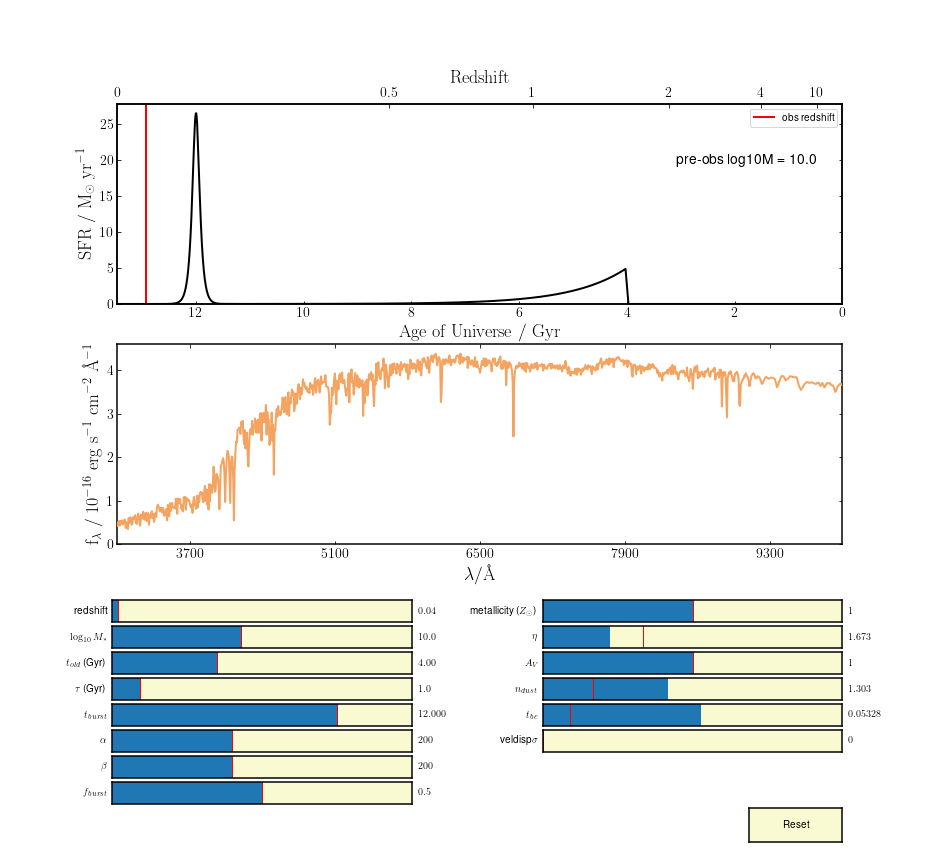

In [342]:
%matplotlib qt
# Create the figure and the line that we will manipulate
fig, ax = plt.subplots(2,1,figsize=[13,12])
init_input_logM, init_sfh, init_custom_sfh = total_mass_at_z(init_logM, init_z, init_t_old, init_t_burst, 
                                                             init_tau, init_alpha, init_beta, init_f_burst)
sfh_line = add_bp_sfh(init_sfh, ax[0])
z_line, = ax[0].plot([cosmo.age(init_z).value,cosmo.age(init_z).value], [0,ax[0].get_ylim()[1]*1000], color='red', 
                     label='obs redshift')
ax[0].legend(loc='upper right')
text = ax[0].text(0.77,0.70,'pre-obs log10M = '+str(np.round(init_input_logM,2)),transform=ax[0].transAxes,fontsize=14)
model = pipes.model_galaxy(make_components(init_z, init_input_logM, init_custom_sfh, init_metallicity,
                                          init_eta, init_Av, init_n_dust, init_t_bc, init_veldisp),
                           spec_wavs=np.linspace(3000,10000,1000))
y_scale_spec,spec_line = add_bp_spectrum(model.spectrum, ax[1])

axcolor = 'lightgoldenrodyellow'
#ax[0].margins(y=100)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(bottom=0.37)
#slider_dims = [left_x, 0.0, 0.75, 0.03]
left_x = 0.12
right_x = 0.58
width = 0.32
height = 0.025

def make_slider(side, y_pos, label, lims, init_val):
    if side == 'left':
        x_pos = left_x
    elif side == 'right':
        x_pos = right_x
    ax_slider = plt.axes([x_pos, y_pos, width, height], facecolor=axcolor)
    the_slider = Slider(
        ax=ax_slider,
        label=label,
        valmin=lims[0],
        valmax=lims[1],
        valinit=init_val,
    )
    return ax_slider, the_slider

# redshift slider
ax_z, z_slider = make_slider('left', 0.28, 'redshift', [0.0,2], init_z)
# logM slider
ax_logM, logM_slider = make_slider('left', 0.25, r'$\log_{10}M_*$', [8.5,12], init_logM)
# t_old slider
ax_t_old, t_old_slider = make_slider('left', 0.22, r'$t_{old}$ (Gyr)', [0,cosmo.age(0).value-2], init_t_old)
# tau slider
ax_tau, tau_slider = make_slider('left', 0.19, r'$\tau$ (Gyr)', [0.1,10], init_tau)
# t_burst slider
ax_t_burst, t_burst_slider = make_slider('left', 0.16, r'$t_{burst}$', [cosmo.age(0).value-5,cosmo.age(0).value-0.3], init_t_burst)
# alpha slider
ax_alpha, alpha_slider = make_slider('left', 0.13, r'$\alpha$', [0.01,500], init_alpha)
# beta slider
ax_beta, beta_slider = make_slider('left', 0.10, r'$\beta$', [0.01,500], init_beta)
# f_burst slider
ax_f_burst, f_burst_slider = make_slider('left', 0.07, r'$f_{burst}$', [0.0,1.0], init_f_burst)
# metallicity slider
ax_metallicity, metallicity_slider = make_slider('right', 0.28, r'metallicity ($Z_{\odot}$)', [0.0,2.0], init_metallicity)
# eta slider
ax_eta, eta_slider = make_slider('right', 0.25, r'$\eta$', [1,4], init_eta)
# Av slider
ax_Av, Av_slider = make_slider('right', 0.22, r'$A_V$', [0,2], init_Av)
# n_dust slider
ax_n_dust, n_dust_slider = make_slider('right', 0.19, r'$n_{dust}$', [0.3,2.7], init_n_dust)
# t_bc slider
ax_t_bc, t_bc_slider = make_slider('right', 0.16, r'$t_{bc}$', [0.001,0.1], init_t_bc)
# veldisp slider
ax_veldisp, veldisp_slider = make_slider('right', 0.13, r'veldisp$\sigma$', [0,400], init_veldisp)

# The function to be called anytime a slider's value changes
def update(val):
    z_line.set_xdata([cosmo.age(z_slider.val).value,cosmo.age(z_slider.val).value])
    input_logM, vary_sfh, custom_sfh = total_mass_at_z(logM_slider.val, 
                                                       z_slider.val, 
                                                       t_old_slider.val, 
                                                       t_burst_slider.val, 
                                                       tau_slider.val, 
                                                       alpha_slider.val, 
                                                       beta_slider.val, 
                                                       f_burst_slider.val)
    sfh_line.set_ydata(vary_sfh[1])
    ax[0].set_ylim(top=1.05*max(vary_sfh[1]))
    text.set_text('pre-obs log10M = '+str(np.round(input_logM,2)))

    #update model components
    new_components = make_components(z_slider.val, input_logM, custom_sfh, metallicity_slider.val,
                                    eta_slider.val, Av_slider.val, n_dust_slider.val, t_bc_slider.val,
                                    veldisp_slider.val)
    model.update(new_components)
    spec_ymax = 1.05*np.max(model.spectrum[:, 1])
    spec_y_scale = int(np.log10(spec_ymax))-1
    spec_line.set_ydata(model.spectrum[:, 1]*10**-spec_y_scale)
    ax[1].set_ylim(0., spec_ymax*10**-spec_y_scale)
    pipes.plotting.auto_axis_label(ax[1], spec_y_scale, z_non_zero=True)
    
    fig.canvas.draw_idle()


# register the update function with each slider
z_slider.on_changed(update)
logM_slider.on_changed(update)
t_old_slider.on_changed(update)
tau_slider.on_changed(update)
t_burst_slider.on_changed(update)
alpha_slider.on_changed(update)
beta_slider.on_changed(update)
f_burst_slider.on_changed(update)

metallicity_slider.on_changed(update)
eta_slider.on_changed(update)
Av_slider.on_changed(update)
n_dust_slider.on_changed(update)
t_bc_slider.on_changed(update)
veldisp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, height, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    z_slider.reset()
    logM_slider.reset()
    f_burst_slider.reset()
    t_old_slider.reset()
    tau_slider.reset()
    t_burst_slider.reset()
    alpha_slider.reset()
    beta_slider.reset()
    
    metallicity_slider.reset()
    eta_slider.reset()
    Av_burst_slider.reset()
    n_dust_slider.reset()
    t_bc_slider.reset()
    veldisp_slider.reset()
button.on_clicked(reset)

plt.show()